In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from scipy.stats import probplot

### Data Collection and Analysis
- We use Yahoo Finance to collect Brent Crude Oil Future (BZ=F) Prices
- From this we calucate the log-returns and volatility.

                                Open       High        Low      Close  Volume  \
Date                                                                            
2023-04-24 00:00:00-04:00  81.599998  82.989998  80.489998  82.730003   16684   
2023-04-25 00:00:00-04:00  82.580002  83.050003  80.349998  80.769997   17134   
2023-04-26 00:00:00-04:00  81.000000  81.470001  77.480003  77.690002   15436   
2023-04-27 00:00:00-04:00  77.870003  78.629997  77.389999  78.370003    8926   
2023-04-28 00:00:00-04:00  78.309998  79.599998  77.970001  79.540001   26788   

                           Dividends  Stock Splits  
Date                                                
2023-04-24 00:00:00-04:00        0.0           0.0  
2023-04-25 00:00:00-04:00        0.0           0.0  
2023-04-26 00:00:00-04:00        0.0           0.0  
2023-04-27 00:00:00-04:00        0.0           0.0  
2023-04-28 00:00:00-04:00        0.0           0.0  


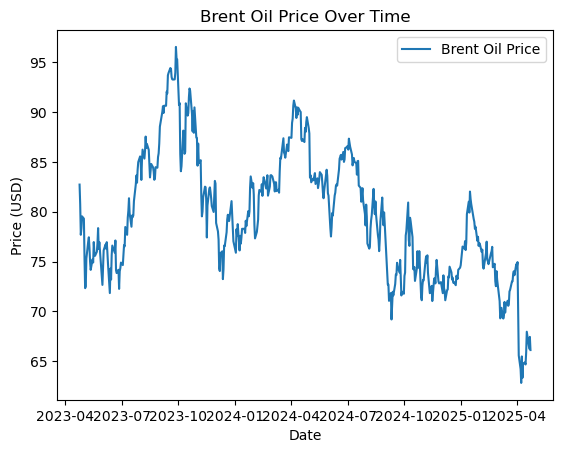

In [43]:
brent_oil = yf.Ticker("BZ=F")
brent_oil_data = brent_oil.history(
    period="2y", interval="1d", start="2023-04-24", end="2025-04-24"
)
print(brent_oil_data.head())
plt.plot(brent_oil_data.index, brent_oil_data["Close"], label="Brent Oil Price")
plt.title("Brent Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

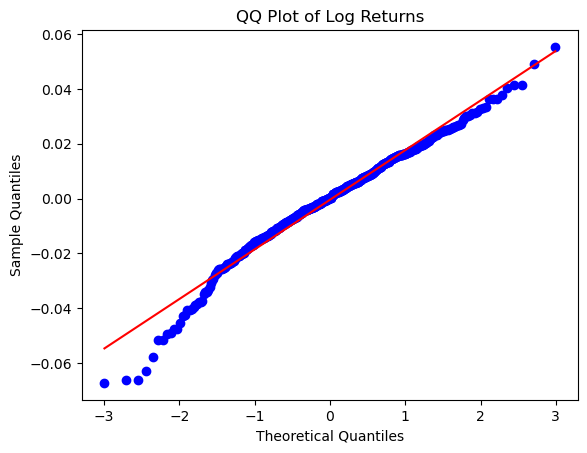

In [44]:
brent_oil_data["Log Returns"] = np.log(
    brent_oil_data["Close"] / brent_oil_data["Close"].shift(1)
)
probplot(brent_oil_data["Log Returns"].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [45]:
annualized_volatility = brent_oil_data["Log Returns"].std() * np.sqrt(252)
print(f"Annualized Volatility: {annualized_volatility:.2%}")

Annualized Volatility: 28.95%


### We need a methodogoly to calculate the rolling average of an asset.

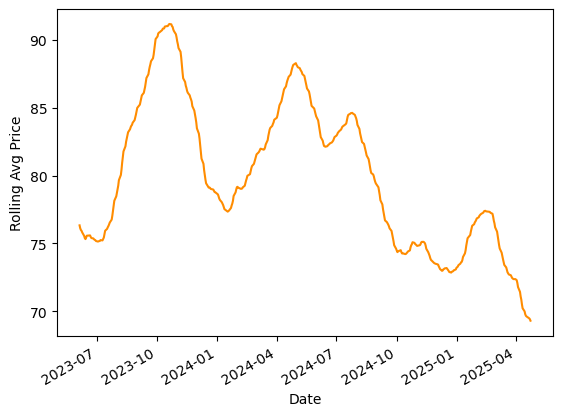

In [46]:
brent_oil_data["Rolling Avg Price"] = brent_oil_data["Close"].rolling(window=30).mean()
brent_oil_data["Rolling Avg Price"].plot(ylabel="Rolling Avg Price", color="darkorange")
plt.show()

### BAPM Pricing Functions

In [47]:
# the following function is used to create a binomial tree for American options
def binomial_tree_regular(S_0, sigma, delta_t, N):
    tree = np.zeros(
        (
            N + 1,
            N + 1,
        )
    )
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    for i in range(N + 1):
        for j in range(i + 1):
            tree[i, j] = S_0 * (u**j) * (d ** (i - j))
    return tree


def generate_asian_nodes(S_0, N, p, u, d):
    # helper function to generate nodes for Asian options
    nodes = {}
    # initial node has time 0, 0 up moves and initial price S_0
    # this also has a probability of 1.0
    nodes[(0, 0, S_0)] = 1.0
    for t in range(1, N + 1):
        new_nodes = {}
        # looping through all the existing nodes in the tree
        for (prev_t, up_moves, cum_sum), prob in nodes.items():
            down_moves = prev_t - up_moves
            # calculating the new up and down prices
            S_up = S_0 * (u ** (up_moves + 1)) * (d**down_moves)
            S_down = S_0 * (u**up_moves) * (d ** (down_moves + 1))
            # updating new nodes with the new up and down prices
            key_up = (t, up_moves + 1, cum_sum + S_up)
            new_nodes[key_up] = new_nodes.get(key_up, 0) + prob * p
            key_down = (t, up_moves, cum_sum + S_down)
            new_nodes[key_down] = new_nodes.get(key_down, 0) + prob * (1 - p)
        nodes = new_nodes
    return nodes


def prob_p(r_f, delta_t, sigma):
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp(r_f * delta_t) - d) / (u - d)
    return p, u, d


def asian_option_valuation(S_0, K, r_f, sigma, T, N, option_type):
    delta_t = T / N
    p, u, d = prob_p(r_f, delta_t, sigma)
    tree_nodes = generate_asian_nodes(S_0, N, p, u, d)
    option_value = 0
    for (t, up_moves, cum_sum), prob in tree_nodes.items():
        # calculating average price at each node
        avg_price = cum_sum / (N + 1)
        if option_type == "call":
            option_value += prob * np.maximum(avg_price - K, 0)
        elif option_type == "put":
            option_value += prob * np.maximum(K - avg_price, 0)
    option_value *= np.exp(-r_f * T)
    return option_value

### Monte Carlo Simulation

In [48]:
def get_paths(S0, T, sigma, r, n_sims, n_steps):
    # Vectorized for efficiency
    dt = T / n_steps
    dZ_matrix = np.random.normal(size=(n_steps, n_sims))
    log_returns = sigma * np.sqrt(dt) * dZ_matrix + ((r - ((sigma**2) / 2)) * dt)
    log_init_price = np.full((1, n_sims), np.log(S0))
    log_prices = np.cumsum(
        np.concatenate((log_init_price, log_returns), axis=0), axis=0
    )
    paths = np.exp(log_prices)
    return paths


def plot_paths(paths, dt, title):
    num_steps = paths.shape[0]
    num_paths = paths.shape[1]
    timesteps = dt * np.arange(num_steps)

    cmap = plt.get_cmap("gist_ncar", num_paths)
    _, ax = plt.subplots()
    for i in range(num_paths):
        color = cmap(i) if num_paths > 1 else "blue"

        ax.plot(timesteps, paths[:, i], color=color, linewidth=0.5)

    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Price")
    ax.set_title(title)
    ax.grid(True)
    plt.show()


def plot_payoffs(payoffs, opt_type):
    mean_payoff = np.mean(payoffs)
    nonzero_payoffs = np.delete(payoffs, np.where(payoffs == 0))
    plt.figure()
    plt.hist(nonzero_payoffs, bins="auto")
    plt.xlabel("Payoff (USD)")
    if opt_type == "call":
        plt.title("Non-Zero, Non-Discounted Simulated Call Option Payoffs")
    elif opt_type == "put":
        plt.title("Non-Zero, Non-Discounted Simulated Put Option Payoffs")
    plt.axvline(
        x=mean_payoff,
        label="Mean Payoff Including Zeros",
        color="black",
        linestyle="--",
    )
    plt.legend()
    plt.show()


def price_asian_option(
    S0, T, sigma, r, n_sims, n_steps, K, opt_type, show_paths=False, show_payoffs=False
):
    # Vectorized for efficiency
    paths = get_paths(S0, T, sigma, r, n_sims, n_steps)
    if show_paths:
        plot_paths(paths, T / n_steps, "Price Paths")

    average_prices = np.mean(paths[1:,], axis=0)  # ignore initial spot price
    payoffs = None
    if opt_type == "call":
        payoffs = np.maximum(average_prices - K, 0)
    elif opt_type == "put":
        payoffs = np.maximum(K - average_prices, 0)
    else:
        raise Exception("invalid option type")

    if show_payoffs:
        plot_payoffs(payoffs, opt_type)

    mean_payoff = np.mean(payoffs)
    discounted_mean_payoff = mean_payoff * np.exp(-1 * r * T)
    return discounted_mean_payoff

### Try with the parameters in the Linetsky Paper

In [49]:
rates = [0.02, 0.18, 0.0125, 0.05, 0.05, 0.05, 0.05]
sigmas = [0.1, 0.3, 0.25, 0.5, 0.5, 0.5, 0.5]
times = [1, 1, 2, 1, 1, 1, 2]
spots = [2, 2, 2, 1.9, 2, 2.1, 2]
taos = [0.0025, 0.0225, 0.03125, 0.0625, 0.0625, 0.0625, 0.125]
K = 2
v = [
    (2 * rates[i] / (sigmas[i] ** 2)) - 1 for i in range(len(rates))
]  # this matches the table, indicating zero dividends
true_prices = [
    0.0559860415,
    0.2183875466,
    0.1722687410,
    0.1931737903,
    0.2464156905,
    0.3062203648,
    0.3500952190,
]
n_sims = 100000

prices = []
for i in range(len(rates)):
    n_steps = int(times[i] * 252)
    call_price = price_asian_option(
        S0=spots[i],
        T=times[i],
        sigma=sigmas[i],
        r=rates[i],
        n_sims=n_sims,
        n_steps=n_steps,
        K=K,
        opt_type="call",
    )
    prices.append(call_price)

prices = np.array(prices)
errors = np.array(true_prices) - prices
print(prices)
print(errors)

[0.0566142  0.219933   0.17292425 0.19635438 0.24671319 0.30987727
 0.34900894]
[-0.00062816 -0.00154545 -0.00065551 -0.00318059 -0.0002975  -0.00365691
  0.00108628]


### Price Asian Options on Brent Crude Oil Futures

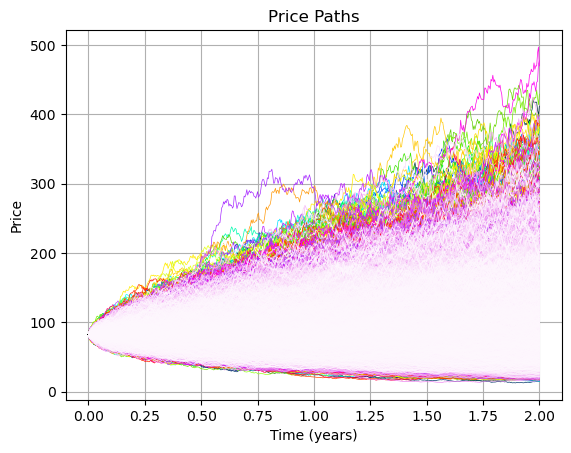

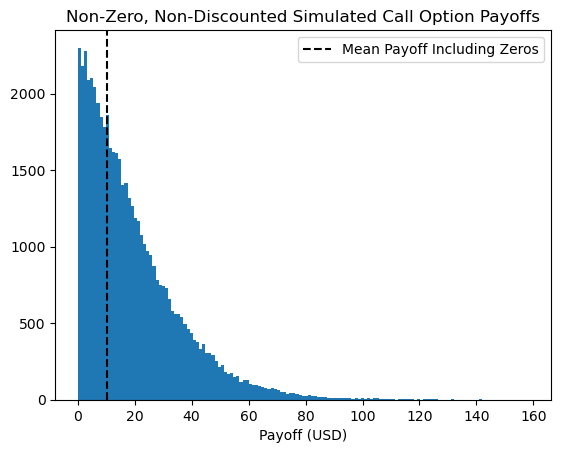

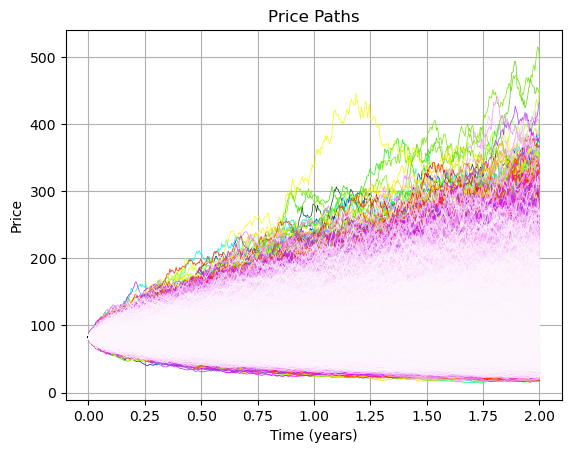

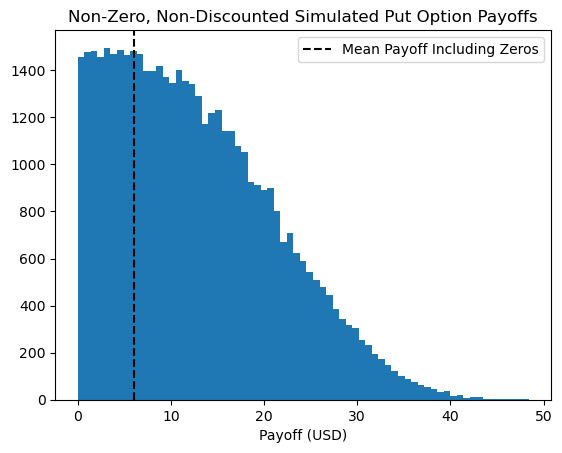

Call Price: 9.336711285666127
Put Price: 5.510027518653667



In [50]:
T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = annualized_volatility
r = 4.12 / 100  # 2-year treasury note yeild on 2023-04-24 from FRED
n_sims = 100000
n_steps = T * 252
K = int(S0)

call_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="call",
    show_paths=True,
    show_payoffs=True,
)
put_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="put",
    show_paths=True,
    show_payoffs=True,
)

print(f"Call Price: {call_price}")
print(f"Put Price: {put_price}")
print(f"")

### To hedge our Asian Options, we need to use the Greeks.

However, for our example, since we are not working with European options, we need to take a different approach to pricing greeks.

In [51]:
def calculate_price_greeks(S0, K, r, sigma, T, n_steps, n_sims, option_type, epsilon=1):
    if option_type == "call":
        price = price_asian_option(
            S0=S0,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
        )
        call_price_up = price_asian_option(
            S0=S0 + epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
        )
        call_price_down = price_asian_option(
            S0=S0 - epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
        )
        delta = (call_price_up - call_price_down) / (2 * epsilon)
        gamma = (call_price_up - 2 * price + call_price_down) / (epsilon**2)
    elif option_type == "put":
        price = price_asian_option(
            S0=S0,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
        )
        put_price_up = price_asian_option(
            S0=S0 + epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
        )
        put_price_down = price_asian_option(
            S0=S0 - epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
        )
        delta = (put_price_up - put_price_down) / (2 * epsilon)
        gamma = (put_price_up - 2 * price + put_price_down) / (epsilon**2)
    return delta, gamma


T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = annualized_volatility
r = 4.12 / 100  # 2-year treasury note yeild on 2023-04-24 from FRED
n_sims = 100000
n_steps = T * 252
K = int(S0)
epsilon = S0 * 0.01

delta_call, gamma_call = calculate_price_greeks(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_sims=n_sims,
    option_type="call",
    epsilon=epsilon,
)
delta_put, gamma_put = calculate_price_greeks(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_sims=n_sims,
    option_type="put",
    epsilon=epsilon,
)
print(f"Call Option Delta: {delta_call:.4f}, Gamma: {gamma_call:.4f}")
print(f"Put Option Delta: {delta_put:.4f}, Gamma: {gamma_put:.4f}")

Call Option Delta: 0.6403, Gamma: 0.1325
Put Option Delta: -0.3744, Gamma: -0.0779
